In [1]:
import bilby
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import math
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from astropy import units as u
from astropy.cosmology import WMAP5

%matplotlib inline

/home/sagi/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
f=h5py.File('/home/sagi/Downloads/models_reduced.hdf5' , 'r')
f.keys()


<KeysViewHDF5 ['CE', 'CHE', 'GC', 'NSC', 'SMT']>

In [3]:
##prints out the data file with its structure
CE_chi02_alpha10 = pd.read_hdf('/home/sagi/Downloads/models_reduced.hdf5', key='/CE/chi02/alpha10/')

In [4]:

##stores all the chirpmass data in an array
data=f['/CE/chi02/alpha10/block0_values']
# Create the nested array
priors = np.array([
    np.array(data[:,0].reshape(-1,1)), # chirpmass
    np.array(data[:,1].reshape(-1,1)), # q
])

names=["chirp mass prior", "q prior"]
chirpmass, q= priors
#print(priors)


In [5]:

kde=[]
samples = [[] for _ in range(len(priors))]
density= [[] for _ in range(len(priors))]
for i in range(len(priors)):
    #priors[i]=priors[i].reshape(-1,1)
    kde.append(KernelDensity(kernel='gaussian', bandwidth=0.2).fit(priors[i][:1000]))
    samples[i]=kde[i].sample(1000)
    density[i]=np.exp(kde[i].score_samples(samples[i][:1000]))
    samples[i]=samples[i].flatten()
    


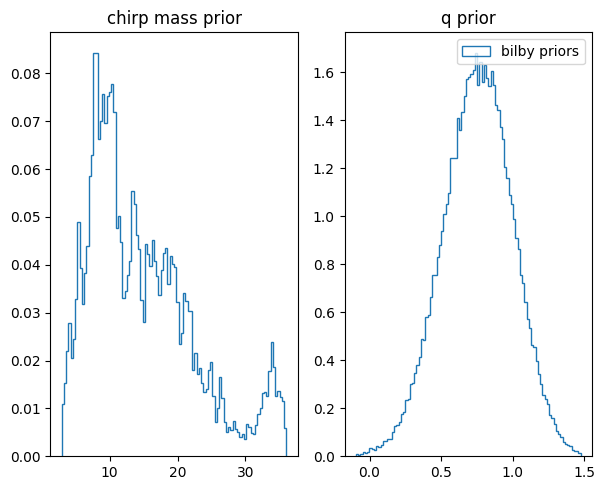

In [6]:

custom_priors = []
fig = plt.figure(figsize=(12, 5))

for i in range(len(names)):
    custom_priors.append (

        bilby.prior.Interped(
            name=names[i],
            xx=samples[i], #plotting chirp mass on the x axis 
            yy=density[i], 
           # minimum=0,
          #  maximum=100,
            #latex_label="chirpmass prior",
        ),
    )

for ii, prior in enumerate(custom_priors):
    fig.add_subplot(1, 4, 1 + ii)
    plt.hist(prior.sample(100000), bins=100, histtype="step", density=True,label="bilby priors")
    plt.title(names[ii])


plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [7]:
data=[]
for i in range(len(names)):

    data.append(zip(samples[i], density[i]))
    
data = [list(zip(samples[i], density[i])) for i in range(len(names))]    

for i, array in enumerate(data):
    with open("{}(CE=1.0).txt".format(names[i]), "w") as file:
        for line in array:
            file.write(",".join(map(str,line)) + "\n")